In [1]:
import random

import math
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem, RDLogger
from rdkit import DataStructs
import rdkit

import molvs
from tqdm import tqdm

## Compound annotation

In [3]:
adata = ad.read_h5ad('../../../data/sciplex3.h5ad')  # raw count data downloaded from pertpy 
drug_metadata = pd.read_csv('../../../data/NIHMS1595611-supplement-TableS3 (1).txt', sep="\t", header=0, skiprows=[0])  #Compound metadata from Srivatsan et. Al. 2020

In [4]:
adata

AnnData object with n_obs × n_vars = 581777 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'

In [5]:
drug_metadata

,well_oligo,plate_oligo,cell_type,replicate,time_point,drug_dose,Combo,catalog_number,vehicle,dose_pattern,dose_character,dose,treatment,CAS.Number,M.w.,name,SMILES
0,plate2_C6,plate49,A549,rep1,72,S0001_1,plate2_C6plate49,S0000,True,1,0,0,S0000,NaN,NaN,NaN,NaN
1,plate2_C12,plate49,A549,rep1,72,S0001_2,plate2_C12plate49,S0000,True,2,0,0,S0000,NaN,NaN,NaN,NaN
2,plate8_C6,plate50,A549,rep1,72,S0001_3,plate8_C6plate50,S0000,True,3,0,0,S0000,NaN,NaN,NaN,NaN
3,plate8_C12,plate50,A549,rep1,72,S0001_4,plate8_C12plate50,S0000,True,4,0,0,S0000,NaN,NaN,NaN,NaN
4,plate9_C6,plate51,A549,rep2,72,S0001_2,plate9_C6plate51,S0000,True,2,0,0,S0000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,plate3_G5,plate9,A549,rep1,24,S8567_1,plate3_G5plate9,S8567,False,1,10000,10000,S8567,1616493-44-7,390.41,Tucidinostat (Chidamide),NC1=C(NC(=O)C2=CC=C(CNC(=O)\C=C\C3=CC=CN=C3)C=...
4988,plate3_F5,plate17,MCF7,rep1,24,S8567_1,plate3_F5plate17,S8567,False,1,10000,10000,S8567,1616493-44-7,390.41,Tucidinostat (Chidamide),NC1=C(NC(=O)C2=CC=C(CNC(=O)\C=C\C3=CC=CN=C3)C=...
4989,plate4_F11,plate26,K562,rep2,24,S8567_1,plate4_F11plate26,S8567,False,1,10000,10000,S8567,1616493-44-7,390.41,Tucidinostat (Chidamide),NC1=C(NC(=O)C2=CC=C(CNC(=O)\C=C\C3=CC=CN=C3)C=...
4990,plate4_F11,plate34,A549,rep2,24,S8567_1,plate4_F11plate34,S8567,False,1,10000,10000,S8567,1616493-44-7,390.41,Tucidinostat (Chidamide),NC1=C(NC(=O)C2=CC=C(CNC(=O)\C=C\C3=CC=CN=C3)C=...


In [6]:
name_SMILES_map = dict(drug_metadata[['name', 'SMILES']].drop_duplicates().values)  # Create a mapping between drug name and corresponding SMILES

In [7]:
name_SMILES_map

{nan: nan,
 'Navitoclax (ABT-263)': 'CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(=O)(=O)C4=CC(=C(C=C4)N[C@H](CCN5CCOCC5)CSC6=CC=CC=C6)S(=O)(=O)C(F)(F)F)C7=CC=C(C=C7)Cl)C',
 'ABT-737': 'CN(C)CCC(CSC1=CC=CC=C1)NC2=CC=C(C=C2[N+]([O-])=O)[S](=O)(=O)NC(=O)C3=CC=C(C=C3)N4CCN(CC4)CC5=C(C=CC=C5)C6=CC=C(Cl)C=C6',
 'Linifanib (ABT-869)': 'CC1=CC(=C(F)C=C1)NC(=O)NC2=CC=C(C=C2)C3=C4C(=N[NH]C4=CC=C3)N',
 'Veliparib (ABT-888)': 'C[C@@]1(CCCN1)C1=NC2=C(C=CC=C2N1)C(N)=O |r,c:11,13,t:7,9|',
 'Roxadustat (FG-4592)': 'CC1=NC(C(=O)NCC(O)=O)=C(O)C2=C1C=C(OC1=CC=CC=C1)C=C2 |c:13,21,23,26,t:1,10,16,19|',
 'Nintedanib (BIBF 1120)': 'COC(=O)C1=CC=C\\2C(=C1)NC(=O)C2=C(NC3=CC=C(C=C3)N(C)C(=O)CN4CCN(C)CC4)/C5=CC=CC=C5',
 'BMS-536924': 'CC1=C2N=C([NH]C2=CC(=C1)N3CCOCC3)C4=C(NCC(O)C5=CC=CC(=C5)Cl)C=CNC4=O',
 'Bosutinib (SKI-606)': 'COC1=C(Cl)C=C(Cl)C(=C1)NC2=C(C=NC3=CC(=C(OC)C=C23)OCCCN4CCN(C)CC4)C#N',
 'Cediranib (AZD2171)': 'COC1=C(OCCCN2CCCC2)C=C3N=CN=C(OC4=C(F)C5=C([NH]C(=C5)C)C=C4)C3=C1',
 'Dasatinib': 'CC1=

In [8]:
#Check that each drug name in adata has a SMILES mapping
for name in adata.obs['product_name'].unique():
    if name == "Vehicle":
        continue
    if name not in name_SMILES_map.keys():
        print(name)

SNS-314
Glesatinib?(MGCD265)


In [9]:
# two drugs do not have the same exact mapping in adata obs, adding them manually in the dict

In [10]:
name_SMILES_map['SNS-314'] = name_SMILES_map['SNS-314 Mesylate']
name_SMILES_map.pop('SNS-314 Mesylate')

name_SMILES_map['Glesatinib?(MGCD265)'] = name_SMILES_map['Glesatinib(MGCD265)']
name_SMILES_map.pop('Glesatinib(MGCD265)')

'C[N]1C=NC(=C1)C2=CC3=NC=CC(=C3S2)OC4=CC=C(NC(=S)NC(=O)CC5=CC=CC=C5)C=C4F'

In [11]:
#Run sanity check again - no drug names should be printed
for name in adata.obs['product_name'].unique():
    if name == "Vehicle":
        continue
    if name not in name_SMILES_map.keys():
        print(name)

In [12]:
#standardize SMILES

md = molvs.metal.MetalDisconnector()
lfc = molvs.fragment.LargestFragmentChooser()
uc = molvs.charge.Uncharger()

def standardize_smiles(smiles):
    std_smiles = molvs.standardize.standardize_smiles(smiles)
    std_mol = Chem.MolFromSmiles(std_smiles)
    std_mol = md.disconnect(std_mol)
    std_mol = lfc.choose(std_mol)
    std_mol = uc.uncharge(std_mol)
    std_smi = Chem.MolToSmiles(std_mol)
    if not molvs.validate.validate_smiles(std_smi):
        #     std_smi = molvs.standardize.canonicalize_tautomer_smiles(std_smi) # Too Slow
        return std_smi

In [13]:
for key in name_SMILES_map.keys():
    if type(key) != str:
        continue
    name_SMILES_map[key] = standardize_smiles(name_SMILES_map[key])

In [14]:
for key in name_SMILES_map.keys():
    if name_SMILES_map[key] is None:
        print(key)

YM155 (Sepantronium Bromide)


In [15]:
#coluld not generate a standardized SMILES for YM155, eliminating it from adata:

adata = adata[adata.obs.product_name != 'YM155 (Sepantronium Bromide)']

In [16]:
adata

View of AnnData object with n_obs × n_vars = 581007 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'

In [17]:
#Create a new column in adata.obs for SMILES
smiles = list()
for name in list(adata.obs['product_name']):
    if name == "Vehicle":
        smiles.append("Vehicle")
    else:
        smiles.append(name_SMILES_map[name])

adata.obs['SMILES'] = smiles

/tmp/ipykernel_2053635/563416812.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['SMILES'] = smiles


In [18]:
#Create morgan fingerprints for SMILES
smiles_to_fmfp = dict()

for sm in list(adata.obs['SMILES'].unique()):

    if sm == 'Vehicle':
        continue
        
    mol = Chem.MolFromSmiles(sm)

    if mol is None:
        print("SMILES could not be converted to RDkit molecule")

    fmfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True, nBits=1024).ToBitString()
    arr = np.array(list(fmfp), dtype=np.float32)

    smiles_to_fmfp[sm] = arr
    
    

[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerator
[15:27:44] DEPRECATION WARNING: please use MorganGenerat

In [19]:
#Create a new column in adata.obs for Feature Morgan Fingerprints
morgan_fps = list()
for sm in list(adata.obs['SMILES']):
    if sm == 'Vehicle':
        morgan_fps.append('Vehicle')
    else:
        morgan_fps.append(smiles_to_fmfp[sm])

adata.obs['fmfp'] = morgan_fps
adata.obs['fmfp'] = adata.obs['fmfp'].apply(
    lambda arr: ','.join(map(str, arr)) if arr is not None else None
)


In [20]:
adata

AnnData object with n_obs × n_vars = 581007 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'SMILES', 'fmfp'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'

## Quality Control

In [21]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

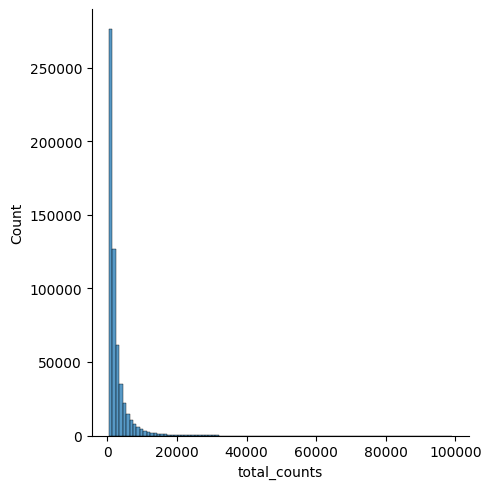

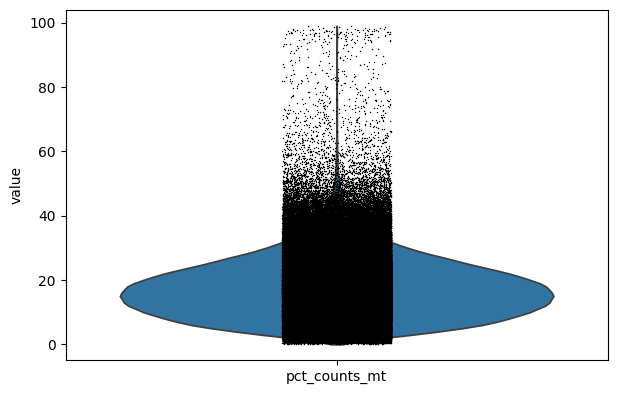

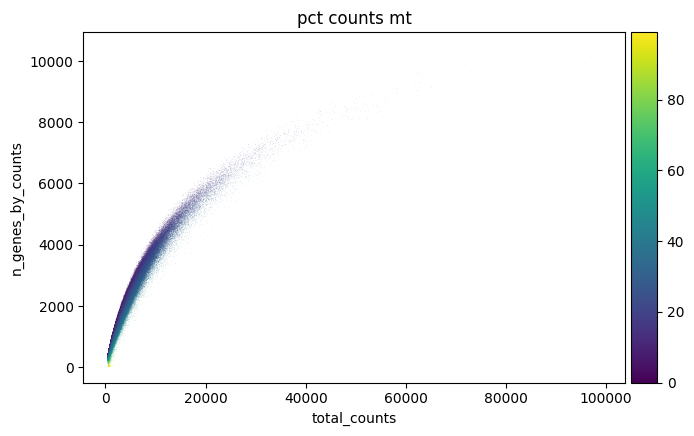

In [22]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [23]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [24]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    575557
True       5450
Name: count, dtype: int64

In [25]:
#Filter out cells that have 3 MADs 

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    559099
True      21908
Name: count, dtype: int64

In [26]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 581007
Number of cells after filtering of low quality cells: 558173


In [27]:
#Filter genes expressed in less than 100 cells
sc.pp.filter_genes(adata, min_cells=100)

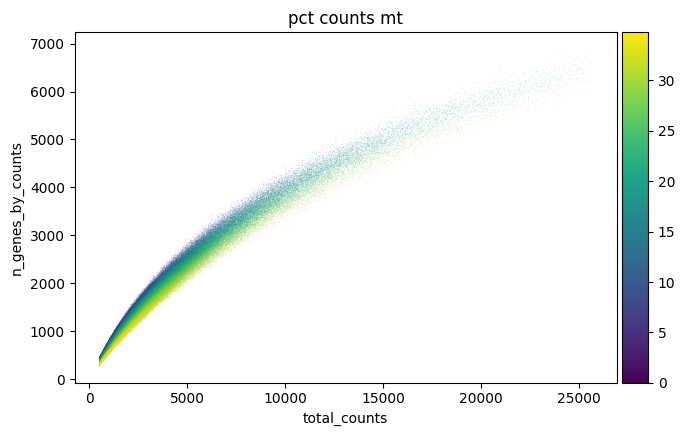

In [28]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color=["pct_counts_mt"])

In [29]:
adata_MCF7 = adata[adata.obs.cell_type == 'MCF7'].copy()
adata_K562 = adata[adata.obs.cell_type == 'K562'].copy()
adata_A549 = adata[adata.obs.cell_type == 'A549'].copy()

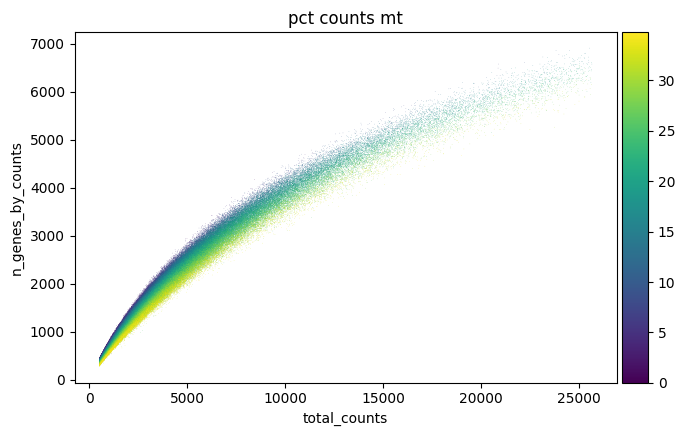

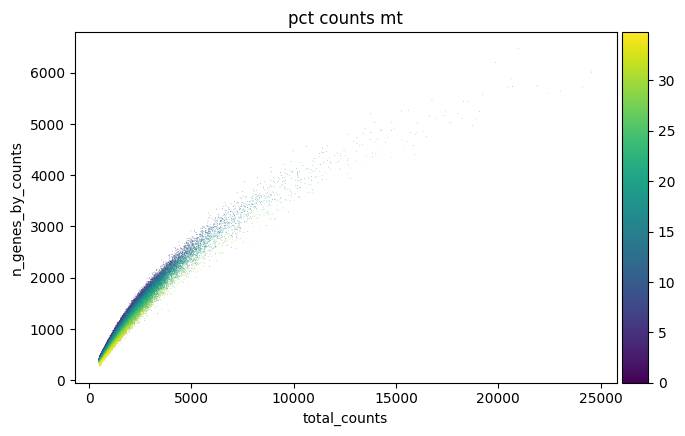

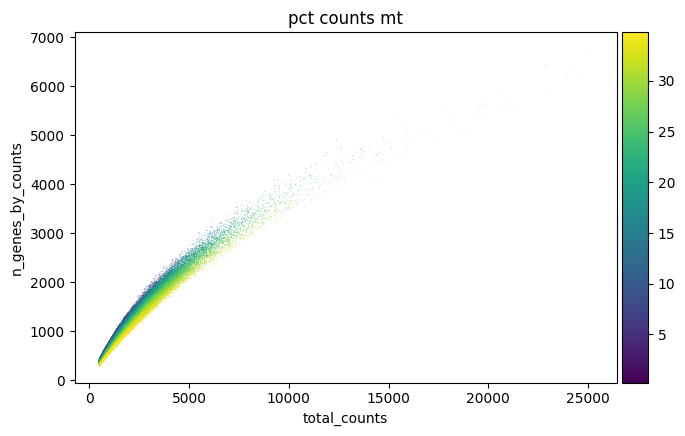

In [30]:
sc.pl.scatter(adata_MCF7, "total_counts", "n_genes_by_counts", color=["pct_counts_mt"])
sc.pl.scatter(adata_K562, "total_counts", "n_genes_by_counts", color=["pct_counts_mt"])
sc.pl.scatter(adata_A549, "total_counts", "n_genes_by_counts", color=["pct_counts_mt"])

In [31]:
adata

AnnData object with n_obs × n_vars = 558173 × 27544
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'SMILES', 'fmfp', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Balance data

In [32]:
#plot the number of cells per unique covariate combination
def plot_obs_distribution(adata, cell_type):
    
    adata_perturbed = adata[adata.obs.product_name != "Vehicle"].copy()
    adata_perturbed = adata_perturbed[adata_perturbed.obs.cell_type == cell_type]
    
    adata_perturbed.obs['drug_celltype'] = adata_perturbed.obs['cell_type'].astype(str) + "_" + adata_perturbed.obs['product_name'].astype(str)
    adata_perturbed.obs['drug_celltype_dose'] = adata_perturbed.obs['cell_type'].astype(str) + "_" + adata_perturbed.obs['product_name'].astype(str)+ "_" + adata_perturbed.obs['dose'].astype(str)
    
    cell_counts_drug = adata_perturbed.obs.drug_celltype.value_counts()
    cell_counts_drug_dose = adata_perturbed.obs.drug_celltype_dose.value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes[0].hist(cell_counts_drug, bins=100, color='blue', edgecolor='black')
    axes[0].set_title(f"{cell_type}: Cells per Drug")
    median_drug = np.median(cell_counts_drug)
    axes[0].axvline(median_drug, color='red', linestyle='dashed', linewidth=2, label=f'Median: {int(median_drug)}')
    axes[0].set_xlabel("Number of Cells")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    
    axes[1].hist(cell_counts_drug_dose, bins=100, color='green', edgecolor='black')
    axes[1].set_title(f"{cell_type}: Cells per unique Drug-Dose combinations")
    median_drug_dose = np.median(cell_counts_drug_dose)
    axes[1].axvline(median_drug_dose, color='red', linestyle='dashed', linewidth=2, label=f'Median: {int(median_drug_dose)}')
    axes[1].set_xlabel("Number of Cells")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2053635/2534818040.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_perturbed.obs['drug_celltype'] = adata_perturbed.obs['cell_type'].astype(str) + "_" + adata_perturbed.obs['product_name'].astype(str)


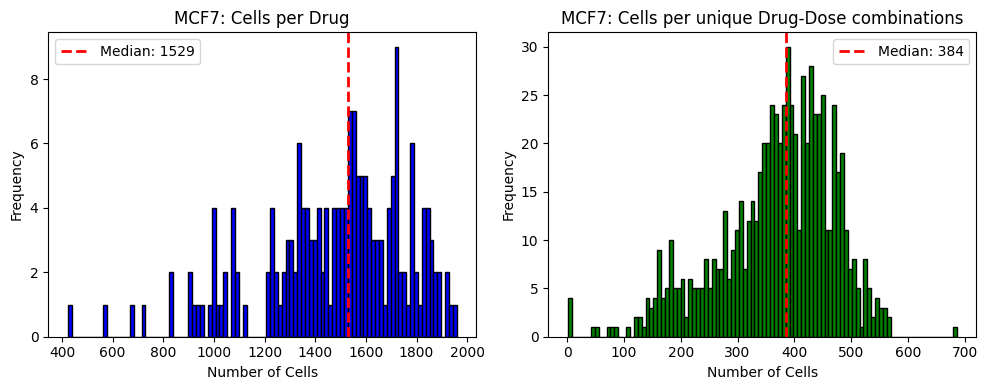

In [33]:
plot_obs_distribution(adata, 'MCF7')

/tmp/ipykernel_2053635/2534818040.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_perturbed.obs['drug_celltype'] = adata_perturbed.obs['cell_type'].astype(str) + "_" + adata_perturbed.obs['product_name'].astype(str)


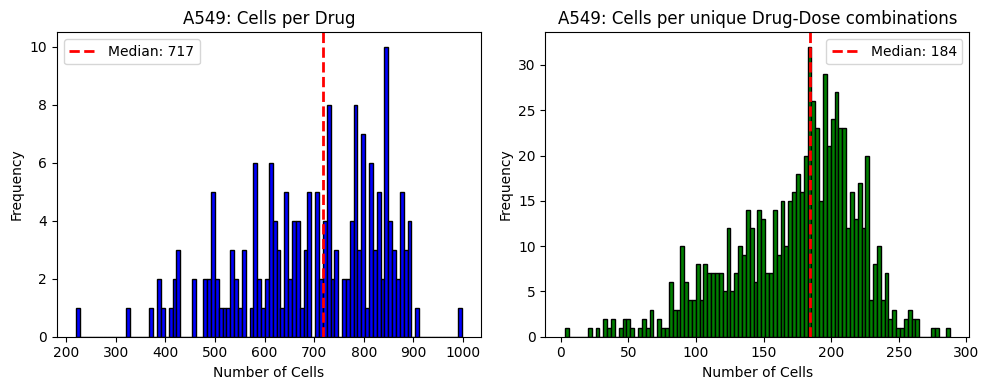

In [34]:
plot_obs_distribution(adata, 'A549')

/tmp/ipykernel_2053635/2534818040.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_perturbed.obs['drug_celltype'] = adata_perturbed.obs['cell_type'].astype(str) + "_" + adata_perturbed.obs['product_name'].astype(str)


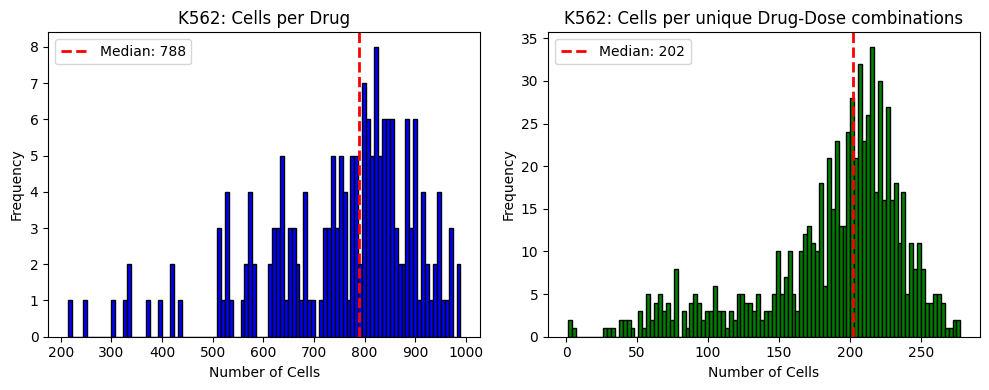

In [35]:
plot_obs_distribution(adata, 'K562')

In [36]:
#cap maximum cells to 200 for unique drug-dose-celltype combinations, and eliminate conditions with less than 50 cells
adata.obs['drug_celltype_dose'] = adata.obs['cell_type'].astype(str) + "_" + adata.obs['product_name'].astype(str)+ "_" + adata.obs['dose'].astype(str)

cell_counts_drug_dose = adata.obs.drug_celltype_dose.value_counts()



In [37]:
cell_counts_drug_dose

drug_celltype_dose
MCF7_Vehicle_0.0                                             6172
K562_Vehicle_0.0                                             3309
A549_Vehicle_0.0                                             3076
MCF7_Mesna _100.0                                             686
MCF7_Cerdulatinib (PRT062070, PRT2070)_10.0                   566
                                                             ... 
A549_Bisindolylmaleimide IX (Ro 31-8220 Mesylate)_10000.0       3
MCF7_Bisindolylmaleimide IX (Ro 31-8220 Mesylate)_10000.0       2
K562_Bisindolylmaleimide IX (Ro 31-8220 Mesylate)_10000.0       2
MCF7_Flavopiridol HCl_10000.0                                   1
K562_Flavopiridol HCl_10000.0                                   1
Name: count, Length: 2247, dtype: int64

In [38]:
conditions_to_eliminate = list()
conditions_to_cap = list()

for i, val in cell_counts_drug_dose.items():
    # if val > 200:
    #     conditions_to_cap.append(i)

    if val < 50:
        conditions_to_eliminate.append(i)



In [39]:
selected_indices = []

for cond in adata.obs.drug_celltype_dose.unique():
    indices = adata.obs[adata.obs.drug_celltype_dose == cond].index
    
    if cond in conditions_to_eliminate:   #eliminate conditions due to too few samples
        continue

    # elif cond.split("_")[0] == "Vehicle": #Don't cap control cells
    #     selected_indices.extend(indices)
    #     continue

    # elif cond in conditions_to_cap:       #Keep only 200 cells from conditions with >200 cells
    #     sampled_cells = np.random.choice(indices, 200, replace=False)
    #     selected_indices.extend(sampled_cells)
    #     continue
        
    else:
        selected_indices.extend(indices)

    
adata = adata[selected_indices]

In [40]:
len(adata.obs.drug_celltype_dose.unique())

2218

In [45]:
assert "Vehicle" in adata.obs.product_name.unique()

## Match Random Controls to each perturbed condition

In [46]:
match_index = list()

control_pool_A549 = adata[(adata.obs['product_name'] == "Vehicle") & (adata.obs['cell_type'] == "A549")]
control_pool_MCF7 = adata[(adata.obs['product_name'] == "Vehicle") & (adata.obs['cell_type'] == "MCF7")]
control_pool_K562 = adata[(adata.obs['product_name'] == "Vehicle") & (adata.obs['cell_type'] == "K562")]

for i, row in adata.obs.iterrows():
    if row['product_name'] == "Vehicle":
        match_index.append("None")
    else:
        if row['cell_type'] == "A549":
            match_index.append(random.choice(list(control_pool_A549.obs_names)))
        elif row['cell_type'] == "MCF7":
            match_index.append(random.choice(list(control_pool_MCF7.obs_names)))
        elif row['cell_type'] == "K562":
            match_index.append(random.choice(list(control_pool_K562.obs_names)))

adata.obs['match_index'] = match_index

/tmp/ipykernel_2053635/2810545533.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['match_index'] = match_index


In [47]:
adata

AnnData object with n_obs × n_vars = 557340 × 27544
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'SMILES', 'fmfp', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'drug_celltype_dose', 'match_index'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Save Anndata object

In [48]:
adata.write_h5ad('../../../data/sciplex_qc_ann_nobalancing.h5ad')